In [10]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim

In [11]:
# デバイスを指定 (GPUが利用可能であればGPUを使用、なければCPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]]).to(device)
    I = torch.eye(3).to(device)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta).to(device)
    sin_theta = torch.sin(theta).to(device)
    
    axis = axis.unsqueeze(0).to(device)  # (1, 3)
    vec = vec.unsqueeze(0).to(device)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs).to(device)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [13]:
# 各CSVファイルの読み込み
csv_files1 = ['xy(1) copy.csv', 'xy(2) copy.csv', 'xy(3) copy.csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['xy1 copy.csv', 'xy2 copy.csv', 'xy3 copy.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換し、GPUに移動
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device))
    y_tensors.append(torch.tensor(y, dtype=torch.float32).to(device))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [14]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [15]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [16]:
# 36通りの組み合わせを生成
permutations = list(itertools.product(itertools.permutations([0, 1, 2]), repeat=2))

# 最適化のためのobjective関数
def objective(trial, perm1, perm2):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(trial.suggest_float('k5', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k6 = torch.tensor(trial.suggest_float('k6', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 全体で最小のLossを保持する変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 36通りの組み合わせごとにエポック計算を行うためのループ
for perm1, perm2 in permutations:
    print(f"Evaluating combination: perm1={perm1}, perm2={perm2}")

    # 最適化のための変数初期化
    best_epoch0_loss = float('inf')
    best_params = None

    for _ in range(5):
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, perm1, perm2), n_trials=100)

        # epoch0のLossが最小のパラメータを保持
        if study.best_value < best_epoch0_loss:
            best_epoch0_loss = study.best_value
            best_params = study.best_params

    # エポック計算 (各組み合わせごとに計算)
    if best_params is not None:
        print(f"Starting training for combination: perm1={perm1}, perm2={perm2}")
        
        k1 = torch.nn.Parameter(torch.tensor(best_params['k1']).to(device))
        k2 = torch.nn.Parameter(torch.tensor(best_params['k2']).to(device))
        k3 = torch.nn.Parameter(torch.tensor(best_params['k3']).to(device))
        k4 = torch.nn.Parameter(torch.tensor(best_params['k4']).to(device))
        k5 = torch.nn.Parameter(torch.tensor(best_params['k5']).to(device))
        k6 = torch.nn.Parameter(torch.tensor(best_params['k6']).to(device))
        t1 = torch.nn.Parameter(torch.tensor(best_params['t1']).to(device))
        p1 = torch.nn.Parameter(torch.tensor(best_params['p1']).to(device))
        t2 = torch.nn.Parameter(torch.tensor(best_params['t2']).to(device))
        p2 = torch.nn.Parameter(torch.tensor(best_params['p2']).to(device))

        optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-1)
        prev_loss = float('inf')

        # エポックごとのトレーニング
        best_params_during_epoch = None  # エポックごとの最良パラメータ
        best_epoch_loss = float('inf')  # 最良のロスを記録

        # エポックごとのトレーニング
        for epoch in range(300000):
            optimizer.zero_grad()

            outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

            y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
            y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

            loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

            if epoch == 0:
                epoch0_loss = loss.item()
                if epoch0_loss >= 35:
                    print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                    break
            
            # 最良のロスを持つ場合はパラメータを保存
            if loss.item() < best_epoch_loss:
                best_epoch_loss = loss.item()
                best_params_during_epoch = {
                    'k1': k1.item(),
                    'k2': k2.item(),
                    'k3': k3.item(),
                    'k4': k4.item(),
                    'k5': k5.item(),
                    'k6': k6.item(),
                    't1': t1.item(),
                    'p1': p1.item(),
                    't2': t2.item(),
                    'p2': p2.item()
                }

            if loss.item() > prev_loss:
                print(f"Loss increased at epoch {epoch}. Stopping training.")
                break

            prev_loss = loss.item()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for param in [k1, k2, k3, k4, k5, k6]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
                for param in [t1, p1, t2, p2]:
                    param.data = torch.clamp(param.data, 0.0, 90.0)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
                # パラメータを表示する
                print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

        # 最良のパラメータを表示
        if best_params_during_epoch is not None:
            print(f"Best params during epoch training: {best_params_during_epoch}")
            # 最良のパラメータをTensorに変換して使用
            k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
        else:
            print("No improvement in loss during epoch training.")

        # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
        if prev_loss < global_best_loss:
            global_best_loss = prev_loss
            global_best_params = best_params_during_epoch
            global_best_combination = (perm1, perm2)

        print(f"Finished training for combination: perm1={perm1}, perm2={perm2}")

# 全体で最も良い組み合わせとパラメータを出力
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-09-27 17:59:57,457] A new study created in memory with name: no-name-a6c3e93f-e817-425d-b8bc-09961ac98e95
[I 2024-09-27 17:59:57,493] Trial 0 finished with value: 370.6871337890625 and parameters: {'k1': -5.004343372924669, 'k2': 4.984813428484534, 'k3': 4.305487811197914, 'k4': 3.2222106491204308, 'k5': -2.521846973127511, 'k6': -1.0304846565644237, 't1': 11.792656426500999, 'p1': 64.55301877221406, 't2': 16.39667506655033, 'p2': 16.205561777241613}. Best is trial 0 with value: 370.6871337890625.
[I 2024-09-27 17:59:57,519] Trial 1 finished with value: 744.788330078125 and parameters: {'k1': -5.372217145124758, 'k2': 9.98675220526868, 'k3': -0.07876931078909521, 'k4': -7.325298381510221, 'k5': 1.127107525575287, 'k6': 8.19639371650458, 't1': 20.55397367286303, 'p1': 74.88709628277643, 't2': 66.55829390767335, 'p2': 73.55724040614307}. Best is trial 0 with value: 370.6871337890625.
[I 2024-09-27 17:59:57,544] Trial 2 finished with value: 207.39581298828125 and parameters: {'k1'

Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-09-27 17:59:57,670] Trial 7 finished with value: 254.47030639648438 and parameters: {'k1': -0.22941917798501876, 'k2': 9.738323192158525, 'k3': -1.2519122435013443, 'k4': -0.057172845478785206, 'k5': -1.9337678955139381, 'k6': 0.028639608412275308, 't1': 33.42715868152256, 'p1': 8.933177804058156, 't2': 69.47185974671717, 'p2': 33.17951482604487}. Best is trial 2 with value: 207.39581298828125.
[I 2024-09-27 17:59:57,797] Trial 8 finished with value: 295.83148193359375 and parameters: {'k1': -2.7191181729162146, 'k2': 9.515610378971616, 'k3': -1.7021466613721454, 'k4': -2.8100863601192767, 'k5': 9.183969898712327, 'k6': 0.8650375902218137, 't1': 55.26858745050866, 'p1': 59.79628933398168, 't2': 8.808048852528952, 'p2': 38.417173644311966}. Best is trial 2 with value: 207.39581298828125.
[I 2024-09-27 17:59:57,821] Trial 9 finished with value: 325.0810852050781 and parameters: {'k1': -3.9828958024283807, 'k2': 8.185671672960524, 'k3': 6.28199018365407, 'k4': -1.0689744336120093,

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 21.52747917175293
Parameters: k1=-8.447495460510254, k2=-1.7974570989608765, k3=1.4109177589416504, k4=5.513146877288818, k5=-4.856507778167725, k6=-3.110680103302002, t1=11.57296371459961, p1=53.50659942626953, t2=87.06233978271484, p2=27.095130920410156
Epoch 100, Loss: 0.2152901440858841
Parameters: k1=-6.391108512878418, k2=-1.0516871213912964, k3=0.009795987978577614, k4=8.301007270812988, k5=-3.5868215560913086, k6=-3.819692373275757, t1=5.409665584564209, p1=53.61671447753906, t2=90.0, p2=27.359283447265625
Epoch 200, Loss: 0.03060806356370449
Parameters: k1=-6.469133377075195, k2=-0.9575262069702148, k3=0.001053631422109902, k4=8.040639877319336, k5=-3.876530170440674, k6=-3.9084012508392334, t1=2.0436103343963623, p1=53.606895446777344, t2=90.0, p2=27.268217086791992
Epoch 300, Loss: 0.0023449286818504333
Parameters: k1=-6.516695499420166, k2=-0.9094250798225403, k3=9.212904842570424e-05, k4=7.9

[I 2024-09-27 18:00:45,251] A new study created in memory with name: no-name-ed92b18a-e96d-46ed-90b1-884fe450ca19
[I 2024-09-27 18:00:45,281] Trial 0 finished with value: 192.53387451171875 and parameters: {'k1': -4.6181335419533776, 'k2': -7.16263667418612, 'k3': -7.480216290379278, 'k4': 4.2284437438655775, 'k5': 9.64130776832301, 'k6': -0.24869631719517926, 't1': 50.819109233950655, 'p1': 29.42160753818047, 't2': 82.5549475322047, 'p2': 10.931044146799954}. Best is trial 0 with value: 192.53387451171875.
[I 2024-09-27 18:00:45,310] Trial 1 finished with value: 126.91683197021484 and parameters: {'k1': 1.1868044328868805, 'k2': -1.2151902607565113, 'k3': -4.795247160746079, 'k4': -1.8528210296226995, 'k5': -2.707831980387791, 'k6': -0.8073034995743367, 't1': 74.1619798167085, 'p1': 24.627906129177386, 't2': 59.62744103540625, 'p2': 20.53033927330896}. Best is trial 1 with value: 126.91683197021484.
[I 2024-09-27 18:00:45,338] Trial 2 finished with value: 395.3339538574219 and paramet

Loss increased at epoch 739. Stopping training.
Best params during epoch training: {'k1': -6.5358099937438965, 'k2': -0.8901896476745605, 'k3': -3.063454414586886e-07, 'k4': 7.850627899169922, 'k5': -4.0418548583984375, 'k6': -3.954946517944336, 't1': 4.947472189087421e-05, 'p1': 53.637351989746094, 't2': 90.0, 'p2': 27.241477966308594}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 1, 2), perm2=(0, 2, 1)


[I 2024-09-27 18:00:45,543] Trial 7 finished with value: 524.1199340820312 and parameters: {'k1': -4.737828113370135, 'k2': -1.521022848255642, 'k3': 7.354424374979381, 'k4': 1.2164032324129401, 'k5': 7.678757336327973, 'k6': -8.57216627603399, 't1': 16.1399477973478, 'p1': 88.79827422801728, 't2': 16.147191519075164, 'p2': 40.88946492234362}. Best is trial 1 with value: 126.91683197021484.
[I 2024-09-27 18:00:45,573] Trial 8 finished with value: 212.92886352539062 and parameters: {'k1': -2.1223079905278137, 'k2': -6.546090889072591, 'k3': 6.779733297657039, 'k4': 2.06668938749263, 'k5': 2.6733945943421595, 'k6': -5.717664955257177, 't1': 70.18443959294454, 'p1': 76.0450324843397, 't2': 45.48901293157247, 'p2': 54.94191602666906}. Best is trial 1 with value: 126.91683197021484.
[I 2024-09-27 18:00:45,599] Trial 9 finished with value: 586.0206298828125 and parameters: {'k1': -2.4032207798337097, 'k2': 5.005168280381957, 'k3': -5.238972737499221, 'k4': 8.655811809235615, 'k5': -7.0921101

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 2, 1)
Epoch 0 Loss is 52.76704788208008, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 2, 1)
Evaluating combination: perm1=(0, 1, 2), perm2=(1, 0, 2)


[I 2024-09-27 18:01:11,414] Trial 4 finished with value: 263.5303955078125 and parameters: {'k1': 7.309220964961931, 'k2': 7.657643768064851, 'k3': 1.354384974090772, 'k4': -4.900588641560402, 'k5': 3.866566746406022, 'k6': -8.38449786132961, 't1': 20.190500060736156, 'p1': 73.81398440177853, 't2': 20.305883751810022, 'p2': 43.13064299483599}. Best is trial 3 with value: 244.82858276367188.
[I 2024-09-27 18:01:11,438] Trial 5 finished with value: 237.5751190185547 and parameters: {'k1': 1.1748087407090892, 'k2': 1.69474179565373, 'k3': 2.8927799707565054, 'k4': 2.4788992953126314, 'k5': 2.6864274419211487, 'k6': -4.583209557637799, 't1': 57.07382766069554, 'p1': 17.521444457779914, 't2': 57.04562255256487, 'p2': 60.43536566623396}. Best is trial 5 with value: 237.5751190185547.
[I 2024-09-27 18:01:11,461] Trial 6 finished with value: 643.2271118164062 and parameters: {'k1': 5.080731734447372, 'k2': 8.64103648235692, 'k3': 0.7621894102384772, 'k4': -6.580385356234412, 'k5': 4.8422511410

Starting training for combination: perm1=(0, 1, 2), perm2=(1, 0, 2)
Epoch 0, Loss: 31.805923461914062
Parameters: k1=6.043060779571533, k2=-8.273096084594727, k3=-3.822841167449951, k4=-3.9594931602478027, k5=8.753487586975098, k6=6.949999809265137, t1=27.30502700805664, p1=31.715579986572266, t2=21.250370025634766, p2=89.79615783691406
Epoch 100, Loss: 18.73377227783203
Parameters: k1=7.9766716957092285, k2=-10.0, k3=-4.10648250579834, k4=-0.8669672012329102, k5=9.236230850219727, k6=10.0, t1=31.224040985107422, p1=39.008602142333984, t2=29.9908390045166, p2=83.43670654296875
Epoch 200, Loss: 17.653676986694336
Parameters: k1=6.599678039550781, k2=-10.0, k3=-4.121247291564941, k4=0.070931576192379, k5=8.931148529052734, k6=10.0, t1=35.75949478149414, p1=41.27784729003906, t2=35.80387878417969, p2=84.21199035644531
Epoch 300, Loss: 17.200239181518555
Parameters: k1=5.946796894073486, k2=-10.0, k3=-4.094757080078125, k4=0.8013665080070496, k5=8.716096878051758, k6=10.0, t1=37.3105201721

[I 2024-09-27 18:01:58,229] A new study created in memory with name: no-name-1024adbd-84ab-4456-8f25-7b9a10a24fda
[I 2024-09-27 18:01:58,255] Trial 0 finished with value: 347.3861083984375 and parameters: {'k1': -4.97087158691865, 'k2': 3.272833473503276, 'k3': -1.6026975194688369, 'k4': 3.5202139499493015, 'k5': 0.22128090710204162, 'k6': 7.7568161690019295, 't1': 78.08253942969043, 'p1': 31.7062999371173, 't2': 0.7931566896667208, 'p2': 27.977564880283918}. Best is trial 0 with value: 347.3861083984375.
[I 2024-09-27 18:01:58,279] Trial 1 finished with value: 297.92266845703125 and parameters: {'k1': -8.68902112271719, 'k2': -9.636156721806952, 'k3': 5.013875720694834, 'k4': 8.402608021097123, 'k5': 6.039825455950126, 'k6': -5.578128131140392, 't1': 38.86317322696293, 'p1': 17.699961434899336, 't2': 67.57801396916598, 'p2': 21.02481419131573}. Best is trial 1 with value: 297.92266845703125.
[I 2024-09-27 18:01:58,304] Trial 2 finished with value: 261.83941650390625 and parameters: {'

Loss increased at epoch 587. Stopping training.
Best params during epoch training: {'k1': 5.297074794769287, 'k2': -10.0, 'k3': -4.087889671325684, 'k4': 1.927217960357666, 'k5': 8.30916976928711, 'k6': 10.0, 't1': 39.55779266357422, 'p1': 50.50160598754883, 't2': 41.35877227783203, 'p2': 90.0}
Finished training for combination: perm1=(0, 1, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(0, 1, 2), perm2=(1, 2, 0)


[I 2024-09-27 18:01:58,520] Trial 8 finished with value: 279.22607421875 and parameters: {'k1': -0.9111293681624737, 'k2': -3.296983875111388, 'k3': 8.535920690142081, 'k4': 1.0155656873346928, 'k5': 0.7703293522424808, 'k6': -5.327873180163372, 't1': 26.279541638295253, 'p1': 61.29912299114838, 't2': 56.59876242279238, 'p2': 73.9687514133455}. Best is trial 5 with value: 220.60708618164062.
[I 2024-09-27 18:01:58,545] Trial 9 finished with value: 242.54515075683594 and parameters: {'k1': -5.3491589565833575, 'k2': -6.435150041507855, 'k3': -4.546985767578295, 'k4': -8.96739180728053, 'k5': -1.3154107563837663, 'k6': 9.568978603961462, 't1': 2.314025235546644, 'p1': 59.80081950803504, 't2': 22.739302967751573, 'p2': 25.735164204780702}. Best is trial 5 with value: 220.60708618164062.
[I 2024-09-27 18:01:58,584] Trial 10 finished with value: 352.3461608886719 and parameters: {'k1': 3.2724253778627688, 'k2': -0.3621766762322238, 'k3': -9.927299682029723, 'k4': 4.267438568032431, 'k5': -8

Starting training for combination: perm1=(0, 1, 2), perm2=(1, 2, 0)
Epoch 0 Loss is 48.5247688293457, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(1, 2, 0)
Evaluating combination: perm1=(0, 1, 2), perm2=(2, 0, 1)


[I 2024-09-27 18:02:22,314] Trial 5 finished with value: 238.5187225341797 and parameters: {'k1': 5.496923709512728, 'k2': -2.4839001363378017, 'k3': -5.8369003326340625, 'k4': 9.345244711192823, 'k5': 8.527599078555234, 'k6': 1.9360442396981448, 't1': 53.95954658116742, 'p1': 72.33946651291639, 't2': 65.45018226554559, 'p2': 84.02446362508765}. Best is trial 0 with value: 163.749267578125.
[I 2024-09-27 18:02:22,379] Trial 6 finished with value: 295.70025634765625 and parameters: {'k1': -1.756543888763332, 'k2': -1.0881912289893307, 'k3': 6.576862059864045, 'k4': 7.954914514358158, 'k5': -1.10606546417889, 'k6': 9.253492465786291, 't1': 79.28595165606735, 'p1': 40.53986465398511, 't2': 84.7260710598587, 'p2': 14.283791764407564}. Best is trial 0 with value: 163.749267578125.
[I 2024-09-27 18:02:22,405] Trial 7 finished with value: 321.7881774902344 and parameters: {'k1': -5.80373782134596, 'k2': 1.8513259839155882, 'k3': 4.338502281438037, 'k4': -0.6669040807980124, 'k5': -8.661792846

Starting training for combination: perm1=(0, 1, 2), perm2=(2, 0, 1)
Epoch 0 Loss is 37.95131301879883, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(2, 0, 1)
Evaluating combination: perm1=(0, 1, 2), perm2=(2, 1, 0)


[I 2024-09-27 18:02:47,758] Trial 6 finished with value: 119.41202545166016 and parameters: {'k1': -4.194250392379577, 'k2': 1.9523531169223123, 'k3': -2.643407397946193, 'k4': -0.7847700747610311, 'k5': -2.693912660730689, 'k6': -0.5044496434367414, 't1': 40.058454258836335, 'p1': 49.48543502004499, 't2': 13.602741379035244, 'p2': 82.63772858602846}. Best is trial 6 with value: 119.41202545166016.
[I 2024-09-27 18:02:47,784] Trial 7 finished with value: 859.05810546875 and parameters: {'k1': 9.699656709204557, 'k2': 8.445136619070752, 'k3': 2.1722411972093703, 'k4': -5.328159184070477, 'k5': -5.109505915679165, 'k6': 4.206287193841947, 't1': 85.64454469015467, 'p1': 59.955802077252805, 't2': 87.22529920930006, 'p2': 75.81312160705512}. Best is trial 6 with value: 119.41202545166016.
[I 2024-09-27 18:02:47,813] Trial 8 finished with value: 244.6591339111328 and parameters: {'k1': -0.19125475895963184, 'k2': -1.38957723164188, 'k3': -0.5691839150478568, 'k4': 2.5017610430732002, 'k5': -

Starting training for combination: perm1=(0, 1, 2), perm2=(2, 1, 0)
Epoch 0 Loss is 74.86283111572266, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(2, 1, 0)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 1, 2)


[I 2024-09-27 18:03:10,816] Trial 5 finished with value: 174.0292205810547 and parameters: {'k1': 1.525926917301275, 'k2': -1.1453112721241059, 'k3': -5.858260876032125, 'k4': -9.02009228915829, 'k5': -2.4871466476915227, 'k6': 7.7739014380028095, 't1': 60.4735512386879, 'p1': 80.58925322988641, 't2': 67.94093573898604, 'p2': 38.80174202796055}. Best is trial 4 with value: 162.09280395507812.
[I 2024-09-27 18:03:10,840] Trial 6 finished with value: 189.0543212890625 and parameters: {'k1': -0.30816768882440293, 'k2': -1.6971510708193378, 'k3': -3.348933996190711, 'k4': 6.691112834809736, 'k5': 2.7887660496907234, 'k6': -0.741097453584981, 't1': 39.7096443123135, 'p1': 71.51285281492854, 't2': 18.78735273785346, 'p2': 38.1892517880553}. Best is trial 4 with value: 162.09280395507812.
[I 2024-09-27 18:03:10,867] Trial 7 finished with value: 206.56695556640625 and parameters: {'k1': 3.5276939890602037, 'k2': 0.6961585875889131, 'k3': -9.179391363440448, 'k4': -4.418370435699394, 'k5': 1.70

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 1, 2)
Epoch 0, Loss: 27.70956039428711
Parameters: k1=-1.6475979089736938, k2=-6.597225189208984, k3=-1.2113032341003418, k4=2.2463631629943848, k5=-6.798578262329102, k6=-2.7313497066497803, t1=37.81742477416992, p1=10.859554290771484, t2=82.29655456542969, p2=57.55766296386719


[I 2024-09-27 18:03:33,407] A new study created in memory with name: no-name-f4644b17-dbbc-4ac5-a61e-da2245b3f7e2
[I 2024-09-27 18:03:33,433] Trial 0 finished with value: 359.5081787109375 and parameters: {'k1': -3.172185951132242, 'k2': 9.768660689349833, 'k3': -6.065435970262905, 'k4': 7.299907752134509, 'k5': -9.15927684296916, 'k6': -3.376205807443342, 't1': 68.29694277691888, 'p1': 0.03952458573566631, 't2': 46.692708642099944, 'p2': 13.83207058691791}. Best is trial 0 with value: 359.5081787109375.
[I 2024-09-27 18:03:33,457] Trial 1 finished with value: 463.4393310546875 and parameters: {'k1': 5.844971648971693, 'k2': 3.8557275696271613, 'k3': -2.936159738061477, 'k4': 7.780272325224203, 'k5': -2.3115488273285596, 'k6': -7.195976895547043, 't1': 21.43732872291583, 'p1': 6.258797681557287, 't2': 59.290160723529155, 'p2': 65.7138029617797}. Best is trial 0 with value: 359.5081787109375.
[I 2024-09-27 18:03:33,482] Trial 2 finished with value: 295.31927490234375 and parameters: {'k

Loss increased at epoch 19. Stopping training.
Best params during epoch training: {'k1': -2.142465591430664, 'k2': -5.1509199142456055, 'k3': -1.461209774017334, 'k4': 1.0239191055297852, 'k5': -6.958329200744629, 'k6': -4.184978008270264, 't1': 36.929203033447266, 'p1': 12.395423889160156, 't2': 83.69857788085938, 'p2': 58.91655731201172}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-09-27 18:03:33,611] Trial 7 finished with value: 606.743896484375 and parameters: {'k1': 4.506942369676132, 'k2': -6.381069013248075, 'k3': 8.26258497218053, 'k4': 1.0670675962901495, 'k5': 3.992534222282707, 'k6': 9.713549119275086, 't1': 17.56867952997642, 'p1': 88.05490799785204, 't2': 41.66745002470866, 'p2': 6.294241683103577}. Best is trial 6 with value: 135.67445373535156.
[I 2024-09-27 18:03:33,638] Trial 8 finished with value: 439.56951904296875 and parameters: {'k1': -6.531674181622041, 'k2': 8.167774528420669, 'k3': 9.672780956938837, 'k4': 1.120138865440353, 'k5': -7.413572729829192, 'k6': -9.815288313536701, 't1': 43.27518346584495, 'p1': 16.56656002941307, 't2': 87.21574663618655, 'p2': 21.463446016084166}. Best is trial 6 with value: 135.67445373535156.
[I 2024-09-27 18:03:33,663] Trial 9 finished with value: 149.12657165527344 and parameters: {'k1': 3.383945005222893, 'k2': -6.277680885701924, 'k3': 0.6466967706370284, 'k4': 6.099473638834635, 'k5': 0.9071033935

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0, Loss: 26.73554229736328
Parameters: k1=2.3052804470062256, k2=-0.8020035028457642, k3=-4.067194938659668, k4=6.811668872833252, k5=-9.165531158447266, k6=-6.712789535522461, t1=0.2076323926448822, p1=89.94058227539062, t2=13.950837135314941, p2=9.040618896484375
Epoch 100, Loss: 20.230751037597656
Parameters: k1=-1.8042988777160645, k2=-2.0559613704681396, k3=-4.047786235809326, k4=4.360384941101074, k5=-5.04693078994751, k6=-10.0, t1=0.0, p1=90.0, t2=22.27474594116211, p2=11.073688507080078


[I 2024-09-27 18:04:00,290] A new study created in memory with name: no-name-416eaefc-30b4-4154-b481-e67040993f5e
[I 2024-09-27 18:04:00,315] Trial 0 finished with value: 325.626953125 and parameters: {'k1': 4.208216048307021, 'k2': -2.4200406580553757, 'k3': -2.2447945635424844, 'k4': 1.7039866554421401, 'k5': -6.185448908885611, 'k6': -9.76476840070021, 't1': 13.33482772606867, 'p1': 89.98000885474667, 't2': 46.21600529639252, 'p2': 38.97771318489286}. Best is trial 0 with value: 325.626953125.
[I 2024-09-27 18:04:00,339] Trial 1 finished with value: 767.6593017578125 and parameters: {'k1': 5.802798944336114, 'k2': -0.24467800777850357, 'k3': 2.264229074734338, 'k4': -8.974627759043765, 'k5': -2.958632814373141, 'k6': 8.730871128486221, 't1': 0.6508908056791429, 'p1': 80.90473245127522, 't2': 86.28701858496505, 'p2': 33.75931110855266}. Best is trial 0 with value: 325.626953125.
[I 2024-09-27 18:04:00,363] Trial 2 finished with value: 93.25285339355469 and parameters: {'k1': -3.96862

Loss increased at epoch 106. Stopping training.
Best params during epoch training: {'k1': -1.8058297634124756, 'k2': -2.045382022857666, 'k3': -4.052798748016357, 'k4': 4.332422733306885, 'k5': -5.018777847290039, 'k6': -10.0, 't1': 0.0, 'p1': 90.0, 't2': 22.38681411743164, 'p2': 11.085824012756348}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(0, 2, 1), perm2=(1, 0, 2)


[I 2024-09-27 18:04:00,509] Trial 8 finished with value: 586.0660400390625 and parameters: {'k1': -5.026883659413695, 'k2': 6.419790415472047, 'k3': 1.2387750486622764, 'k4': 9.651418560965837, 'k5': -3.966554504074489, 'k6': 5.2359316470416175, 't1': 68.27879384106899, 'p1': 21.866586323604512, 't2': 71.85067275657615, 'p2': 78.42083588490605}. Best is trial 2 with value: 93.25285339355469.
[I 2024-09-27 18:04:00,534] Trial 9 finished with value: 345.2474670410156 and parameters: {'k1': 5.8225336062460755, 'k2': 2.1627385101355188, 'k3': 2.8520487911675847, 'k4': 2.6531440174426084, 'k5': -7.619832688998274, 'k6': 8.591654494757758, 't1': 39.62877109047295, 'p1': 30.883093504791084, 't2': 55.23348423177019, 'p2': 23.185934086755854}. Best is trial 2 with value: 93.25285339355469.
[I 2024-09-27 18:04:00,574] Trial 10 finished with value: 109.66387939453125 and parameters: {'k1': -7.865534371990202, 'k2': -7.406195769267032, 'k3': -3.378393572321019, 'k4': 8.327198932756506, 'k5': 1.053

Starting training for combination: perm1=(0, 2, 1), perm2=(1, 0, 2)
Epoch 0 Loss is 50.90217590332031, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(1, 0, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(1, 2, 0)


[I 2024-09-27 18:04:23,080] Trial 6 finished with value: 324.3084716796875 and parameters: {'k1': -2.192289181599774, 'k2': 4.6474072927522485, 'k3': -7.106367738576482, 'k4': -8.53007515198354, 'k5': -5.008654211709351, 'k6': 9.412275614355057, 't1': 4.1324549548642935, 'p1': 73.65515481532276, 't2': 18.463669540565633, 'p2': 2.416799192061909}. Best is trial 4 with value: 77.82371520996094.
[I 2024-09-27 18:04:23,108] Trial 7 finished with value: 757.5711059570312 and parameters: {'k1': 3.26816296375155, 'k2': 7.369504119552115, 'k3': 8.751556775776145, 'k4': -7.229928543368789, 'k5': 0.2431537230688363, 'k6': -5.492453737090754, 't1': 68.26384613371114, 'p1': 86.0382186729262, 't2': 6.299776177153489, 'p2': 43.754290304778074}. Best is trial 4 with value: 77.82371520996094.
[I 2024-09-27 18:04:23,135] Trial 8 finished with value: 295.1532897949219 and parameters: {'k1': -3.318627204557247, 'k2': -2.217984595729881, 'k3': -5.5977983703194685, 'k4': -4.8747761629317825, 'k5': -3.49618

Starting training for combination: perm1=(0, 2, 1), perm2=(1, 2, 0)
Epoch 0 Loss is 62.02338409423828, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(1, 2, 0)
Evaluating combination: perm1=(0, 2, 1), perm2=(2, 0, 1)


[I 2024-09-27 18:04:46,388] Trial 5 finished with value: 189.43789672851562 and parameters: {'k1': -5.998952897527971, 'k2': 3.532190904635188, 'k3': -0.4732880518063194, 'k4': -7.552590682321025, 'k5': -7.6482020488560964, 'k6': 4.990268206628468, 't1': 60.391211688568525, 'p1': 84.96584656316735, 't2': 33.25010044174671, 'p2': 72.3147343088194}. Best is trial 4 with value: 188.7704315185547.
[I 2024-09-27 18:04:46,462] Trial 6 finished with value: 243.3079376220703 and parameters: {'k1': 0.4185779238673941, 'k2': 3.9283357660967315, 'k3': -7.938713745325727, 'k4': -0.7007599551754335, 'k5': -1.185447384679975, 'k6': -3.1807983010238168, 't1': 64.16425346867669, 'p1': 39.2403457823509, 't2': 74.71968167948762, 'p2': 33.972369158822644}. Best is trial 4 with value: 188.7704315185547.
[I 2024-09-27 18:04:46,488] Trial 7 finished with value: 330.32659912109375 and parameters: {'k1': -9.676628586682266, 'k2': -3.5890599546643482, 'k3': 7.243344572150338, 'k4': -3.827472451699969, 'k5': 4.

Starting training for combination: perm1=(0, 2, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 26.326213836669922
Parameters: k1=-0.18843808770179749, k2=-5.845873832702637, k3=-2.7969651222229004, k4=2.753418207168579, k5=-5.817041397094727, k6=-7.6603474617004395, t1=0.24364638328552246, p1=58.09629440307617, t2=23.661487579345703, p2=41.27667236328125
Epoch 100, Loss: 18.521635055541992
Parameters: k1=4.003486633300781, k2=-8.024360656738281, k3=-4.0029425621032715, k4=2.0623650550842285, k5=-6.52833890914917, k6=-10.0, t1=0.0, p1=60.09516525268555, t2=21.494436264038086, p2=39.64207077026367
Epoch 200, Loss: 18.204647064208984
Parameters: k1=6.157310485839844, k2=-10.0, k3=-3.991234064102173, k4=1.6373306512832642, k5=-6.876699447631836, k6=-10.0, t1=0.0, p1=60.09531021118164, t2=20.551971435546875, p2=43.857749938964844
Epoch 300, Loss: 18.098047256469727
Parameters: k1=8.093208312988281, k2=-10.0, k3=-4.137664794921875, k4=1.395394206047058, k5=-7.142110347747803, k6=-10.0, t1=0.0, p1=60.095

[I 2024-09-27 18:05:29,730] A new study created in memory with name: no-name-7ea04c0d-ee72-455c-b50b-414a172b6e15
[I 2024-09-27 18:05:29,755] Trial 0 finished with value: 458.1214599609375 and parameters: {'k1': 3.829501467958007, 'k2': -8.568932905991094, 'k3': 4.202022424770233, 'k4': -6.293338675664765, 'k5': 8.312473902081084, 'k6': -9.677717688543394, 't1': 6.7394738407059265, 'p1': 21.848548553783324, 't2': 41.11531537699336, 'p2': 2.8648990732243873}. Best is trial 0 with value: 458.1214599609375.
[I 2024-09-27 18:05:29,781] Trial 1 finished with value: 1022.7205200195312 and parameters: {'k1': 9.02857165238143, 'k2': 9.258892106563327, 'k3': 9.005117774365882, 'k4': 5.469809543461082, 'k5': -2.539057085464851, 'k6': -7.367384763726134, 't1': 16.283106954000043, 'p1': 69.71277854585296, 't2': 61.28545794665606, 'p2': 57.42306451581497}. Best is trial 0 with value: 458.1214599609375.
[I 2024-09-27 18:05:29,805] Trial 2 finished with value: 228.93417358398438 and parameters: {'k1'

Loss increased at epoch 487. Stopping training.
Best params during epoch training: {'k1': 8.918484687805176, 'k2': -10.0, 'k3': -4.19177770614624, 'k4': 1.3061699867248535, 'k5': -7.259019374847412, 'k6': -10.0, 't1': 0.0, 'p1': 60.09531021118164, 't2': 19.641569137573242, 'p2': 47.26868438720703}
Finished training for combination: perm1=(0, 2, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(0, 2, 1), perm2=(2, 1, 0)


[I 2024-09-27 18:05:29,953] Trial 8 finished with value: 249.439453125 and parameters: {'k1': -3.495411713111558, 'k2': 3.3105552561897085, 'k3': 8.087863342414657, 'k4': 1.1069035175534463, 'k5': -6.8262956490987525, 'k6': 7.7897399296065295, 't1': 22.37125989338194, 'p1': 39.11819093651667, 't2': 61.74198236567884, 'p2': 35.95511513195839}. Best is trial 5 with value: 220.34190368652344.
[I 2024-09-27 18:05:29,977] Trial 9 finished with value: 273.1688537597656 and parameters: {'k1': -6.7875605149299645, 'k2': -0.47323831974554764, 'k3': 2.9085999150600728, 'k4': -5.2784204329885664, 'k5': 5.087643138513691, 'k6': 0.5432592523134225, 't1': 31.581241004314286, 'p1': 75.15541714284417, 't2': 70.51291175069102, 'p2': 31.23080585148689}. Best is trial 5 with value: 220.34190368652344.
[I 2024-09-27 18:05:30,015] Trial 10 finished with value: 318.57470703125 and parameters: {'k1': 1.7024557907053453, 'k2': -4.709348733789295, 'k3': -8.865000946287822, 'k4': -9.782392222762375, 'k5': -9.68

Starting training for combination: perm1=(0, 2, 1), perm2=(2, 1, 0)
Epoch 0 Loss is 56.6235466003418, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(2, 1, 0)
Evaluating combination: perm1=(1, 0, 2), perm2=(0, 1, 2)


[I 2024-09-27 18:05:51,325] Trial 4 finished with value: 396.0686950683594 and parameters: {'k1': 3.197602352270547, 'k2': 3.7183224136478756, 'k3': -5.271026232458569, 'k4': 3.735999343032038, 'k5': -4.160579405568681, 'k6': -6.578756180874315, 't1': 21.48868459052876, 'p1': 16.98851387999327, 't2': 68.1768037141812, 'p2': 13.400129594969133}. Best is trial 2 with value: 279.98638916015625.
[I 2024-09-27 18:05:51,348] Trial 5 finished with value: 620.9859619140625 and parameters: {'k1': -9.125982174472815, 'k2': 1.3213156617817727, 'k3': 9.988522299992578, 'k4': 4.083875336419203, 'k5': -9.007560796275767, 'k6': 1.9526272843241372, 't1': 30.00731836748742, 'p1': 66.83734622023607, 't2': 18.81554968427312, 'p2': 24.911988143609246}. Best is trial 2 with value: 279.98638916015625.
[I 2024-09-27 18:05:51,410] Trial 6 finished with value: 321.8272705078125 and parameters: {'k1': -8.525345444942317, 'k2': -6.673969020464168, 'k3': -6.0883722458477285, 'k4': 7.5088114882116095, 'k5': 0.9336

Starting training for combination: perm1=(1, 0, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 32.891632080078125
Parameters: k1=-8.214731216430664, k2=-4.472358703613281, k3=-3.581968307495117, k4=-7.295037746429443, k5=-3.627497434616089, k6=9.077860832214355, t1=21.08995246887207, p1=86.19164276123047, t2=16.176315307617188, p2=24.62638282775879
Epoch 100, Loss: 19.285802841186523
Parameters: k1=-2.4863717555999756, k2=-3.168240547180176, k3=-3.9804461002349854, k4=-6.701417446136475, k5=-3.0026443004608154, k6=10.0, t1=19.145084381103516, p1=90.0, t2=22.076282501220703, p2=19.587074279785156
Epoch 200, Loss: 19.226892471313477
Parameters: k1=-1.8080638647079468, k2=-3.328748941421509, k3=-4.08700704574585, k4=-6.605781555175781, k5=-3.078765392303467, k6=10.0, t1=18.859655380249023, p1=90.0, t2=22.103086471557617, p2=17.809513092041016
Epoch 300, Loss: 19.169227600097656
Parameters: k1=-1.3638126850128174, k2=-3.6320369243621826, k3=-4.100595951080322, k4=-6.504680156707764, k5=-3.202296972274

[I 2024-09-27 18:06:38,325] A new study created in memory with name: no-name-e28a1859-eef1-43c0-9dd6-3ea56000d942
[I 2024-09-27 18:06:38,351] Trial 0 finished with value: 390.0517883300781 and parameters: {'k1': 7.139954796683796, 'k2': -7.454199204650589, 'k3': -9.31900650141989, 'k4': 3.617893027898372, 'k5': -3.8245561573139275, 'k6': -3.260106262415907, 't1': 83.27201732751148, 'p1': 89.90959328390005, 't2': 1.5701158524604886, 'p2': 85.69228700546013}. Best is trial 0 with value: 390.0517883300781.
[I 2024-09-27 18:06:38,379] Trial 1 finished with value: 314.63397216796875 and parameters: {'k1': -8.868523215199085, 'k2': -9.658840732632575, 'k3': -7.125261340839404, 'k4': 2.142186917434021, 'k5': -4.322286125326869, 'k6': 3.531634131631833, 't1': 46.645640928675, 'p1': 13.647270147024027, 't2': 58.192879347640734, 'p2': 78.59210733056929}. Best is trial 1 with value: 314.63397216796875.
[I 2024-09-27 18:06:38,405] Trial 2 finished with value: 133.41807556152344 and parameters: {'k

Loss increased at epoch 636. Stopping training.
Best params during epoch training: {'k1': 1.6150319576263428, 'k2': -5.436481952667236, 'k3': -4.184154510498047, 'k4': -5.818149566650391, 'k5': -3.9779179096221924, 'k6': 10.0, 't1': 11.841328620910645, 'p1': 90.0, 't2': 20.363794326782227, 'p2': 0.0}
Finished training for combination: perm1=(1, 0, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(1, 0, 2), perm2=(0, 2, 1)


[I 2024-09-27 18:06:38,529] Trial 7 finished with value: 333.346923828125 and parameters: {'k1': 7.919004743309738, 'k2': -9.124048380670292, 'k3': 1.8428167930276302, 'k4': -5.675101861773635, 'k5': -7.910393725074694, 'k6': 1.1712268223038276, 't1': 63.92642291707769, 'p1': 79.92060084375422, 't2': 13.236917895965936, 'p2': 31.535128882943287}. Best is trial 3 with value: 123.7950668334961.
[I 2024-09-27 18:06:38,556] Trial 8 finished with value: 221.95819091796875 and parameters: {'k1': -5.962630509771407, 'k2': -8.017998970852238, 'k3': 2.541117023815696, 'k4': 6.741115444108374, 'k5': -7.121614439989516, 'k6': -1.2860213569333911, 't1': 41.15853682465682, 'p1': 86.5949528512104, 't2': 70.81171400846956, 'p2': 47.253992268454674}. Best is trial 3 with value: 123.7950668334961.
[I 2024-09-27 18:06:38,581] Trial 9 finished with value: 726.9239501953125 and parameters: {'k1': -0.5042927475013492, 'k2': 6.831248213835135, 'k3': 8.994019302267485, 'k4': 6.265897800544973, 'k5': -5.92958

Starting training for combination: perm1=(1, 0, 2), perm2=(0, 2, 1)
Epoch 0 Loss is 37.26469039916992, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-09-27 18:07:00,869] Trial 6 finished with value: 465.2115478515625 and parameters: {'k1': 0.2559944012622637, 'k2': 4.657078416680704, 'k3': -0.23677144380623893, 'k4': -6.713608195394363, 'k5': 6.434775987244478, 'k6': -7.972221949827604, 't1': 46.904500049293155, 'p1': 23.06527020929054, 't2': 5.114821986415973, 'p2': 50.28972195291213}. Best is trial 0 with value: 154.17364501953125.
[I 2024-09-27 18:07:00,916] Trial 7 finished with value: 371.4642333984375 and parameters: {'k1': 8.471212415255547, 'k2': -0.988684274842214, 'k3': -2.466288043856501, 'k4': 2.4610260113172533, 'k5': -5.937946239247149, 'k6': 3.532271741513748, 't1': 83.19017164702986, 'p1': 76.93944824760463, 't2': 80.36166421159663, 'p2': 8.227378436641533}. Best is trial 0 with value: 154.17364501953125.
[I 2024-09-27 18:07:00,951] Trial 8 finished with value: 226.4259490966797 and parameters: {'k1': -8.010977137018337, 'k2': -6.088102768309316, 'k3': 9.180164048788363, 'k4': -0.8402519961097976, 'k5': 6.512

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0 Loss is 41.276832580566406, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 2, 0)


[I 2024-09-27 18:07:22,507] Trial 7 finished with value: 713.1069946289062 and parameters: {'k1': 6.779013910962526, 'k2': 9.748888400123377, 'k3': -0.9830003079495384, 'k4': 2.9858127532026106, 'k5': -3.3479978479723123, 'k6': 1.0876861914007492, 't1': 40.060349970499125, 'p1': 79.36608929522241, 't2': 60.434182431662, 'p2': 32.52832561589557}. Best is trial 0 with value: 149.97503662109375.
[I 2024-09-27 18:07:22,574] Trial 8 finished with value: 316.1419982910156 and parameters: {'k1': 7.108266200339344, 'k2': -9.042117844493252, 'k3': -4.168607025219686, 'k4': -7.669966106445695, 'k5': -6.612135486431676, 'k6': -5.221755672274748, 't1': 73.4976257524021, 'p1': 2.0245977057393327, 't2': 6.801424636861734, 'p2': 53.131241615404534}. Best is trial 0 with value: 149.97503662109375.
[I 2024-09-27 18:07:22,600] Trial 9 finished with value: 281.6727600097656 and parameters: {'k1': -2.6274240417858614, 'k2': -2.822859479418005, 'k3': -3.1601780171616145, 'k4': 3.7832642290126035, 'k5': -4.

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 2, 0)
Epoch 0 Loss is 38.78291702270508, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 2, 0)
Evaluating combination: perm1=(1, 0, 2), perm2=(2, 0, 1)


[I 2024-09-27 18:07:44,504] Trial 6 finished with value: 387.27850341796875 and parameters: {'k1': -7.0491851056777, 'k2': 3.683645647914595, 'k3': -7.0482818176880535, 'k4': -9.380502829200587, 'k5': -7.9055129022644355, 'k6': 1.2853989971353137, 't1': 21.18574503569241, 'p1': 58.81692281706791, 't2': 77.08346571826245, 'p2': 46.26151766603946}. Best is trial 2 with value: 112.640869140625.
[I 2024-09-27 18:07:44,530] Trial 7 finished with value: 199.83322143554688 and parameters: {'k1': -7.601878274725498, 'k2': -5.111502354142461, 'k3': 1.070630102991517, 'k4': 0.23891491315993818, 'k5': 4.556105145200149, 'k6': -8.334390752951666, 't1': 16.384450627087787, 'p1': 86.27779958030499, 't2': 15.543529863925032, 'p2': 11.331494622035631}. Best is trial 2 with value: 112.640869140625.
[I 2024-09-27 18:07:44,556] Trial 8 finished with value: 537.2090454101562 and parameters: {'k1': -1.8126295813668634, 'k2': 5.2805092154129305, 'k3': 4.462565645218188, 'k4': 8.836269747824062, 'k5': -2.921

Starting training for combination: perm1=(1, 0, 2), perm2=(2, 0, 1)
Epoch 0 Loss is 69.5975112915039, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(2, 0, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(2, 1, 0)


[I 2024-09-27 18:08:05,882] Trial 7 finished with value: 466.7856750488281 and parameters: {'k1': -8.834552687975997, 'k2': -8.23988230012861, 'k3': 4.616891704608781, 'k4': 8.03886605478975, 'k5': -4.226286436820996, 'k6': 7.980688281101202, 't1': 53.74971321942164, 'p1': 83.93747885545247, 't2': 7.434999753496539, 'p2': 23.91991408228045}. Best is trial 1 with value: 244.6177520751953.
[I 2024-09-27 18:08:05,908] Trial 8 finished with value: 389.9154052734375 and parameters: {'k1': -0.647119485929128, 'k2': 9.85033102891742, 'k3': -2.04391869369503, 'k4': 2.9850533271643975, 'k5': 5.881499533866171, 'k6': -8.259434174049122, 't1': 86.96098781925885, 'p1': 81.41828667563037, 't2': 3.320033142312492, 'p2': 7.671096592338532}. Best is trial 1 with value: 244.6177520751953.
[I 2024-09-27 18:08:05,931] Trial 9 finished with value: 472.1861572265625 and parameters: {'k1': 1.991654851927521, 'k2': 6.423109019139545, 'k3': -9.695034463425305, 'k4': -4.8080750756885005, 'k5': -7.3706907395478

Starting training for combination: perm1=(1, 0, 2), perm2=(2, 1, 0)
Epoch 0 Loss is 41.84931182861328, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(2, 1, 0)
Evaluating combination: perm1=(1, 2, 0), perm2=(0, 1, 2)


[I 2024-09-27 18:08:28,316] Trial 5 finished with value: 268.0249328613281 and parameters: {'k1': -4.16466041606999, 'k2': 9.248554139720305, 'k3': -9.988410352530934, 'k4': 0.8058655494878622, 'k5': -6.577939449723626, 'k6': -2.0387027804112385, 't1': 38.86680789990556, 'p1': 88.00236756728339, 't2': 76.99751666868049, 'p2': 88.45901853293758}. Best is trial 0 with value: 213.5198974609375.
[I 2024-09-27 18:08:28,388] Trial 6 finished with value: 345.464111328125 and parameters: {'k1': -0.49951045412305284, 'k2': 6.4728704744486905, 'k3': -5.128625953602688, 'k4': 9.324385157716815, 'k5': 4.854292357234245, 'k6': -4.431426589553196, 't1': 71.82841067341566, 'p1': 40.52852444191458, 't2': 69.45559712867055, 'p2': 82.5663675174672}. Best is trial 0 with value: 213.5198974609375.
[I 2024-09-27 18:08:28,414] Trial 7 finished with value: 524.964111328125 and parameters: {'k1': 4.961816291121435, 'k2': -7.696536021121084, 'k3': -9.5951651985086, 'k4': -8.46469834559747, 'k5': 8.431959072172

Starting training for combination: perm1=(1, 2, 0), perm2=(0, 1, 2)
Epoch 0 Loss is 41.012298583984375, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(0, 1, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(0, 2, 1)


[I 2024-09-27 18:08:47,264] Trial 8 finished with value: 261.7159118652344 and parameters: {'k1': 2.11649403551586, 'k2': -8.462293817214055, 'k3': -0.06907475639133587, 'k4': 4.13665643546252, 'k5': 8.901370700743339, 'k6': -4.756683445146546, 't1': 84.97596993645224, 'p1': 14.887430977081918, 't2': 70.1766311193023, 'p2': 14.798536657278898}. Best is trial 0 with value: 137.50479125976562.
[I 2024-09-27 18:08:47,285] Trial 9 finished with value: 415.94403076171875 and parameters: {'k1': 5.897303906231983, 'k2': 5.3187644443543505, 'k3': 2.479967592810379, 'k4': 0.21949967560002115, 'k5': 1.353823875602549, 'k6': 7.160510180280987, 't1': 69.5561784253604, 'p1': 56.06166139327551, 't2': 2.616785860839934, 'p2': 27.438358562716104}. Best is trial 0 with value: 137.50479125976562.
[I 2024-09-27 18:08:47,322] Trial 10 finished with value: 144.08578491210938 and parameters: {'k1': -2.5136303757476917, 'k2': -1.673909661000292, 'k3': -7.155061341286024, 'k4': -9.680166531855292, 'k5': -3.89

Starting training for combination: perm1=(1, 2, 0), perm2=(0, 2, 1)
Epoch 0 Loss is 64.54756164550781, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 0, 2)


[I 2024-09-27 18:09:05,353] Trial 8 finished with value: 301.12860107421875 and parameters: {'k1': -4.610261056322691, 'k2': 4.89276921131335, 'k3': 2.2758494644106833, 'k4': 6.5817251558765655, 'k5': 9.06372189439164, 'k6': -9.122026765850507, 't1': 58.70265929380458, 'p1': 9.557656816495811, 't2': 35.44174555134934, 'p2': 74.013709179969}. Best is trial 1 with value: 167.56289672851562.
[I 2024-09-27 18:09:05,381] Trial 9 finished with value: 222.92031860351562 and parameters: {'k1': 8.027850021656107, 'k2': -7.716801261235617, 'k3': -1.2037085502355698, 'k4': 2.7227588806666887, 'k5': -3.123168274169064, 'k6': 1.9533071291203186, 't1': 27.851067846981145, 'p1': 42.18777901152037, 't2': 67.39259655718912, 'p2': 85.37389331024336}. Best is trial 1 with value: 167.56289672851562.
[I 2024-09-27 18:09:05,429] Trial 10 finished with value: 515.3729858398438 and parameters: {'k1': 2.902257433660626, 'k2': -3.0941474139874305, 'k3': 9.794703237320215, 'k4': -8.861342618321897, 'k5': 1.65496

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 0, 2)
Epoch 0, Loss: 20.349658966064453
Parameters: k1=7.01438570022583, k2=-7.119027137756348, k3=-4.038262367248535, k4=0.35261958837509155, k5=9.802301406860352, k6=-0.8293837308883667, t1=75.96835327148438, p1=4.5242133140563965, t2=23.640941619873047, p2=51.99470520019531
Epoch 100, Loss: 7.6866230964660645
Parameters: k1=4.483290672302246, k2=-6.191115379333496, k3=-4.140125751495361, k4=-0.9733912348747253, k5=7.89025354385376, k6=1.3737140893936157, t1=82.18131256103516, p1=0.35690587759017944, t2=28.990371704101562, p2=57.201820373535156
Epoch 200, Loss: 6.8169450759887695
Parameters: k1=4.436293125152588, k2=-5.665672779083252, k3=-4.254734992980957, k4=-0.7614923119544983, k5=7.6672682762146, k6=0.8008873462677002, t1=90.0, p1=0.0, t2=31.89480209350586, p2=59.37455368041992
Epoch 300, Loss: 6.790834903717041
Parameters: k1=4.297234535217285, k2=-5.402770519256592, k3=-4.299472332000732, k4=-0.6774812340736389, k5=

[I 2024-09-27 18:09:34,904] A new study created in memory with name: no-name-d0ec1e08-9985-45ad-9b91-2e2c4b73da3c
[I 2024-09-27 18:09:34,927] Trial 0 finished with value: 279.85845947265625 and parameters: {'k1': -8.86146517757323, 'k2': -4.348046754520176, 'k3': 9.661002964107869, 'k4': -1.1646005429876496, 'k5': -1.4670986995412338, 'k6': 3.139359729046138, 't1': 86.88029144684002, 'p1': 27.138656364067007, 't2': 47.677743996203525, 'p2': 1.3413320013756436}. Best is trial 0 with value: 279.85845947265625.
[I 2024-09-27 18:09:34,948] Trial 1 finished with value: 405.1006164550781 and parameters: {'k1': -7.164760485743809, 'k2': -6.5796629451908455, 'k3': -9.528531671107817, 'k4': 0.14344749856358874, 'k5': 8.942405013163068, 'k6': -3.7723486144576412, 't1': 48.49722522309553, 'p1': 3.1283774863207405, 't2': 81.56635518055032, 'p2': 46.128946467108555}. Best is trial 0 with value: 279.85845947265625.
[I 2024-09-27 18:09:34,969] Trial 2 finished with value: 268.31756591796875 and param

Loss increased at epoch 328. Stopping training.
Best params during epoch training: {'k1': 4.29237699508667, 'k2': -5.393860816955566, 'k3': -4.300964832305908, 'k4': -0.6745325922966003, 'k5': 7.57611083984375, 'k6': 0.8137296438217163, 't1': 90.0, 'p1': 0.0, 't2': 32.42988204956055, 'p2': 60.305824279785156}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-09-27 18:09:35,123] Trial 9 finished with value: 560.5811157226562 and parameters: {'k1': -6.331202650543526, 'k2': 4.619215076981478, 'k3': 1.7731507464964835, 'k4': 9.324835120604128, 'k5': -3.131133399013894, 'k6': 6.635265794533694, 't1': 73.18767744972683, 'p1': 46.7060963075622, 't2': 0.11173863033478337, 'p2': 52.258981858724304}. Best is trial 4 with value: 224.4849090576172.
[I 2024-09-27 18:09:35,159] Trial 10 finished with value: 488.9579772949219 and parameters: {'k1': 9.608882273030645, 'k2': -9.832592743987409, 'k3': -4.176513711726445, 'k4': -5.4114995592231, 'k5': -8.303165698372982, 'k6': -9.735879984382516, 't1': 5.219105900763317, 'p1': 1.6551594577121236, 't2': 27.972394833098498, 'p2': 30.75708009607869}. Best is trial 4 with value: 224.4849090576172.
[I 2024-09-27 18:09:35,193] Trial 11 finished with value: 272.23944091796875 and parameters: {'k1': -1.377343242847763, 'k2': -3.6058259043852914, 'k3': -2.3085263105225344, 'k4': 7.059105459382513, 'k5': 3.94

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0, Loss: 14.693195343017578
Parameters: k1=-8.248259544372559, k2=0.567645251750946, k3=-0.4314054548740387, k4=-7.89018440246582, k5=-3.2154929637908936, k6=5.065963268280029, t1=12.969223022460938, p1=88.88473510742188, t2=89.67573547363281, p2=40.55002212524414


[I 2024-09-27 18:09:54,280] A new study created in memory with name: no-name-4468b11e-ffb7-4b73-b32b-46f8729f5f2a
[I 2024-09-27 18:09:54,301] Trial 0 finished with value: 614.924560546875 and parameters: {'k1': 7.740926529984925, 'k2': 6.438249730177112, 'k3': -1.8594379824672629, 'k4': -0.7894717448524915, 'k5': 7.1539435686784465, 'k6': 2.355796089248866, 't1': 89.81492231396149, 'p1': 45.86602872070707, 't2': 81.00582698290958, 'p2': 43.67166575684465}. Best is trial 0 with value: 614.924560546875.
[I 2024-09-27 18:09:54,329] Trial 1 finished with value: 182.077392578125 and parameters: {'k1': -1.905117393627723, 'k2': 0.9565067289558815, 'k3': 0.07092165925407734, 'k4': 4.025337581090573, 'k5': 2.8694342801152946, 'k6': -1.0023566813761668, 't1': 56.081434514695005, 'p1': 21.044947651951624, 't2': 20.815297640289998, 'p2': 82.13553766475582}. Best is trial 1 with value: 182.077392578125.
[I 2024-09-27 18:09:54,358] Trial 2 finished with value: 441.0885009765625 and parameters: {'k1

Loss increased at epoch 23. Stopping training.
Best params during epoch training: {'k1': -6.680273532867432, 'k2': -0.6763798594474792, 'k3': 0.27685031294822693, 'k4': -7.703173637390137, 'k5': -4.507109642028809, 'k6': 3.2925519943237305, 't1': 11.128753662109375, 'p1': 87.0048828125, 't2': 87.97832489013672, 'p2': 40.01270294189453}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(1, 2, 0), perm2=(2, 0, 1)


[I 2024-09-27 18:09:54,515] Trial 7 finished with value: 285.0458984375 and parameters: {'k1': -0.23405332954621372, 'k2': -5.959984692623291, 'k3': -6.105475463796051, 'k4': -7.1414183893662475, 'k5': 7.524656241828964, 'k6': -1.1188820386911242, 't1': 75.00890036959238, 'p1': 70.2673055517299, 't2': 32.738496292308355, 'p2': 58.51791729594438}. Best is trial 5 with value: 162.50863647460938.
[I 2024-09-27 18:09:54,537] Trial 8 finished with value: 223.35914611816406 and parameters: {'k1': 2.3537876954807206, 'k2': -8.095305714161817, 'k3': 0.7926607871923075, 'k4': -4.521108922289576, 'k5': 4.8565609365502915, 'k6': 6.763210551209497, 't1': 20.414952338012693, 'p1': 39.15854541963913, 't2': 8.599001362904618, 'p2': 27.456481927544026}. Best is trial 5 with value: 162.50863647460938.
[I 2024-09-27 18:09:54,558] Trial 9 finished with value: 134.2516632080078 and parameters: {'k1': -6.899298042268773, 'k2': 4.405168538017641, 'k3': -5.59117098460403, 'k4': -1.0266648594730334, 'k5': -0.

Starting training for combination: perm1=(1, 2, 0), perm2=(2, 0, 1)
Epoch 0 Loss is 67.27761840820312, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(2, 0, 1)
Evaluating combination: perm1=(1, 2, 0), perm2=(2, 1, 0)


[I 2024-09-27 18:10:13,515] Trial 8 finished with value: 397.01983642578125 and parameters: {'k1': 7.0044302898850965, 'k2': -5.955635111135324, 'k3': 4.441713409101805, 'k4': 0.10855247380965061, 'k5': 6.451446112382818, 'k6': 6.26378367522268, 't1': 23.773355831545036, 'p1': 20.202047348500205, 't2': 87.3510016478657, 'p2': 39.81331806749297}. Best is trial 4 with value: 113.01176452636719.
[I 2024-09-27 18:10:13,545] Trial 9 finished with value: 409.37518310546875 and parameters: {'k1': 4.428600857459433, 'k2': 3.7976951672983734, 'k3': 8.394257374863649, 'k4': 5.400225006065501, 'k5': -9.606015214807591, 'k6': 5.315577520545647, 't1': 34.37405052662112, 'p1': 89.6185945571934, 't2': 85.42234015677566, 'p2': 63.72450871827642}. Best is trial 4 with value: 113.01176452636719.
[I 2024-09-27 18:10:13,580] Trial 10 finished with value: 296.8636474609375 and parameters: {'k1': -7.628143650500558, 'k2': 9.92264885847831, 'k3': -2.1943327075394747, 'k4': 9.983827400086703, 'k5': -2.5680553

Starting training for combination: perm1=(1, 2, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 33.485374450683594
Parameters: k1=-8.533013343811035, k2=-4.389303684234619, k3=8.532970428466797, k4=-2.7881345748901367, k5=1.9592643976211548, k6=9.247702598571777, t1=45.448238372802734, p1=71.98125457763672, t2=58.706764221191406, p2=58.2720832824707
Epoch 100, Loss: 25.682558059692383
Parameters: k1=-4.182682514190674, k2=-6.309946060180664, k3=2.8553590774536133, k4=-3.117474317550659, k5=4.952756881713867, k6=10.0, t1=49.30155944824219, p1=78.01390838623047, t2=58.13646697998047, p2=59.5726203918457
Epoch 200, Loss: 16.83576202392578
Parameters: k1=3.240095376968384, k2=-10.0, k3=-4.32017707824707, k4=-0.626221239566803, k5=9.786685943603516, k6=10.0, t1=57.29023742675781, p1=86.91635131835938, t2=52.72751998901367, p2=66.5857162475586


[I 2024-09-27 18:10:40,202] A new study created in memory with name: no-name-5754ef26-ba3b-4b77-a5d2-9ef5412e5388
[I 2024-09-27 18:10:40,282] Trial 0 finished with value: 142.7696533203125 and parameters: {'k1': -2.966281715013233, 'k2': 4.72255521222252, 'k3': -3.3505174068710026, 'k4': 2.1752773961294825, 'k5': -6.302380720799476, 'k6': 0.10018571355946193, 't1': 17.01121273064631, 'p1': 1.647406827549207, 't2': 29.522181827655942, 'p2': 32.389344599324374}. Best is trial 0 with value: 142.7696533203125.
[I 2024-09-27 18:10:40,302] Trial 1 finished with value: 163.8539276123047 and parameters: {'k1': -8.249510613272179, 'k2': -6.393400800150129, 'k3': 0.26251090999959104, 'k4': 1.8563748899405734, 'k5': 1.8749141772525348, 'k6': -4.034750719863515, 't1': 36.228084801128325, 'p1': 49.8540752791625, 't2': 0.0028325434486142775, 'p2': 34.991655057694025}. Best is trial 0 with value: 142.7696533203125.
[I 2024-09-27 18:10:40,324] Trial 2 finished with value: 230.67491149902344 and parame

Loss increased at epoch 248. Stopping training.
Best params during epoch training: {'k1': 3.022796392440796, 'k2': -10.0, 'k3': -4.030636787414551, 'k4': 0.3062286674976349, 'k5': 9.7644681930542, 'k6': 10.0, 't1': 57.38142395019531, 'p1': 90.0, 't2': 51.32079315185547, 'p2': 68.96196746826172}
Finished training for combination: perm1=(1, 2, 0), perm2=(2, 1, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(0, 1, 2)


[I 2024-09-27 18:10:40,410] Trial 6 finished with value: 473.1733703613281 and parameters: {'k1': -0.2875936822570786, 'k2': 2.6963871942267303, 'k3': 6.596328471864222, 'k4': 6.077444077463923, 'k5': -1.0285024859486551, 'k6': -2.4535627012929284, 't1': 36.02788048075686, 'p1': 46.57376613421677, 't2': 67.39680439352583, 'p2': 89.98686955960227}. Best is trial 3 with value: 95.71438598632812.
[I 2024-09-27 18:10:40,434] Trial 7 finished with value: 96.8120346069336 and parameters: {'k1': -6.38541320976445, 'k2': 7.46675058998591, 'k3': -1.5700431527556553, 'k4': 6.573140854124826, 'k5': -2.362128552969125, 'k6': 8.782632944609293, 't1': 25.14659329638391, 'p1': 25.478693954217615, 't2': 3.0920851686672313, 'p2': 42.85385026254077}. Best is trial 3 with value: 95.71438598632812.
[I 2024-09-27 18:10:40,456] Trial 8 finished with value: 384.3401184082031 and parameters: {'k1': 0.6617595943504462, 'k2': -2.350969216810661, 'k3': -2.5190475511009787, 'k4': 4.910013201950461, 'k5': 4.059462

Starting training for combination: perm1=(2, 0, 1), perm2=(0, 1, 2)
Epoch 0 Loss is 53.6620979309082, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(0, 1, 2)
Evaluating combination: perm1=(2, 0, 1), perm2=(0, 2, 1)


[I 2024-09-27 18:10:58,538] Trial 6 finished with value: 312.3673095703125 and parameters: {'k1': -1.3111844022224322, 'k2': -3.050076729654627, 'k3': 9.311098086676182, 'k4': -8.52712814750549, 'k5': 4.341609986972255, 'k6': 3.9234402575377594, 't1': 34.12403090620577, 'p1': 65.4605644428773, 't2': 89.22550665989934, 'p2': 3.2335484388973237}. Best is trial 3 with value: 214.0586395263672.
[I 2024-09-27 18:10:58,571] Trial 7 finished with value: 542.9725341796875 and parameters: {'k1': -7.802954270080782, 'k2': 9.432622178018693, 'k3': -5.510966099947339, 'k4': -0.45163084386903485, 'k5': 5.157171578545341, 'k6': -2.3198161076294666, 't1': 38.67162678730781, 'p1': 57.888889352534044, 't2': 74.79170735614458, 'p2': 47.34451832494116}. Best is trial 3 with value: 214.0586395263672.
[I 2024-09-27 18:10:58,593] Trial 8 finished with value: 186.9664306640625 and parameters: {'k1': 4.78108389676729, 'k2': -9.36337985700084, 'k3': -8.760135617546288, 'k4': 7.790857998009308, 'k5': -9.3538585

Starting training for combination: perm1=(2, 0, 1), perm2=(0, 2, 1)
Epoch 0 Loss is 38.00261306762695, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(2, 0, 1), perm2=(1, 0, 2)


[I 2024-09-27 18:11:16,929] Trial 8 finished with value: 873.5774536132812 and parameters: {'k1': -1.3733622289304357, 'k2': 4.783251267174682, 'k3': 7.868724130634888, 'k4': -9.635773980362384, 'k5': -9.245024469132526, 'k6': -7.487998812648138, 't1': 55.16509041568636, 'p1': 27.954403934281263, 't2': 19.669477774416848, 'p2': 70.86679007413036}. Best is trial 3 with value: 113.53297424316406.
[I 2024-09-27 18:11:16,960] Trial 9 finished with value: 359.2956848144531 and parameters: {'k1': -3.607516900548891, 'k2': -5.2948089468006465, 'k3': 3.7952964778070566, 'k4': 5.4480845480941476, 'k5': 8.649301502562196, 'k6': 4.474016679464498, 't1': 67.02282457479087, 'p1': 42.17967624072856, 't2': 62.840612201709035, 'p2': 80.80670442529288}. Best is trial 3 with value: 113.53297424316406.
[I 2024-09-27 18:11:17,029] Trial 10 finished with value: 454.03753662109375 and parameters: {'k1': -7.778525334114052, 'k2': -9.9962204604611, 'k3': -9.769064317368287, 'k4': -4.111836308531225, 'k5': 3.9

Starting training for combination: perm1=(2, 0, 1), perm2=(1, 0, 2)
Epoch 0 Loss is 68.99019622802734, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(1, 0, 2)
Evaluating combination: perm1=(2, 0, 1), perm2=(1, 2, 0)


[I 2024-09-27 18:11:34,961] Trial 8 finished with value: 436.1324157714844 and parameters: {'k1': -8.618946672937643, 'k2': -3.0168454848713484, 'k3': 3.1015601945740805, 'k4': 7.2537198535129725, 'k5': -2.7534317731257074, 'k6': -9.527425386733197, 't1': 0.42415810545505805, 'p1': 33.998845905149494, 't2': 46.11305525799096, 'p2': 15.975215444803537}. Best is trial 6 with value: 131.53817749023438.
[I 2024-09-27 18:11:34,986] Trial 9 finished with value: 732.017578125 and parameters: {'k1': 8.10418658616776, 'k2': 8.970975632268505, 'k3': 6.620163652080315, 'k4': 9.859371036396645, 'k5': -2.0905891531044407, 'k6': 3.9450843816397008, 't1': 34.6331677489577, 'p1': 78.7996606616027, 't2': 15.742962218901319, 'p2': 71.0094128368542}. Best is trial 6 with value: 131.53817749023438.
[I 2024-09-27 18:11:35,063] Trial 10 finished with value: 317.2496643066406 and parameters: {'k1': 2.6839181542775346, 'k2': -8.102773955111255, 'k3': 9.183384853694147, 'k4': 1.7680696351599177, 'k5': 2.762219

Starting training for combination: perm1=(2, 0, 1), perm2=(1, 2, 0)
Epoch 0 Loss is 41.223026275634766, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-09-27 18:11:53,272] Trial 8 finished with value: 240.27711486816406 and parameters: {'k1': -0.9497990877446583, 'k2': 3.7891260739533923, 'k3': 2.4144131277232983, 'k4': -3.94953900513409, 'k5': -3.6670806731474492, 'k6': -0.7348956224725267, 't1': 74.4699138327999, 'p1': 44.404497573799475, 't2': 64.93966648543591, 'p2': 49.198168319355716}. Best is trial 6 with value: 131.08636474609375.
[I 2024-09-27 18:11:53,350] Trial 9 finished with value: 431.98663330078125 and parameters: {'k1': -7.655471338930234, 'k2': -1.510736500784871, 'k3': -3.2359157655909936, 'k4': 2.932311995406609, 'k5': 0.40882211179576444, 'k6': -7.846707854995689, 't1': 12.304726092958479, 'p1': 17.94685176999164, 't2': 76.29951233052904, 'p2': 58.53097106504598}. Best is trial 6 with value: 131.08636474609375.
[I 2024-09-27 18:11:53,383] Trial 10 finished with value: 426.8166198730469 and parameters: {'k1': -9.19175763417172, 'k2': -8.517270178860027, 'k3': 9.765440767778742, 'k4': 7.525757987293316, 'k5':

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 34.97615051269531
Parameters: k1=-2.8074705600738525, k2=-5.034083843231201, k3=-2.15289568901062, k4=7.6981682777404785, k5=1.96065354347229, k6=7.211750030517578, t1=80.46660614013672, p1=37.36516571044922, t2=27.98121452331543, p2=6.707745552062988
Epoch 100, Loss: 12.009507179260254
Parameters: k1=-6.842459678649902, k2=-0.12735305726528168, k3=-2.9868483543395996, k4=7.909791946411133, k5=2.9041783809661865, k6=5.098307132720947, t1=72.09112548828125, p1=42.09197998046875, t2=34.82570266723633, p2=0.9611822962760925
Epoch 200, Loss: 9.960268020629883
Parameters: k1=-8.178452491760254, k2=0.8443730473518372, k3=-3.096553325653076, k4=8.772819519042969, k5=2.376399278640747, k6=6.025844573974609, t1=66.66930389404297, p1=38.50320816040039, t2=37.33668899536133, p2=3.3587779998779297
Epoch 300, Loss: 8.687891960144043
Parameters: k1=-9.768265724182129, k2=2.222700834274292, k3=-3.2155187129974365, k4=9

[I 2024-09-27 18:12:52,621] A new study created in memory with name: no-name-8bcb3774-73a2-40c7-a3c1-6cf86c509419
[I 2024-09-27 18:12:52,643] Trial 0 finished with value: 445.7891845703125 and parameters: {'k1': 8.727235984080664, 'k2': 9.97446775694112, 'k3': -8.294243848002498, 'k4': -6.291050909179021, 'k5': -6.721747899634289, 'k6': -2.949379263232732, 't1': 71.9454024945148, 'p1': 0.23605778832293423, 't2': 16.093453281401736, 'p2': 12.292200515434688}. Best is trial 0 with value: 445.7891845703125.
[I 2024-09-27 18:12:52,665] Trial 1 finished with value: 315.30633544921875 and parameters: {'k1': 8.824941057734513, 'k2': 6.100891793752933, 'k3': -2.020511855395908, 'k4': -2.2749936332123433, 'k5': 6.442400060220148, 'k6': 6.551487977153794, 't1': 40.738326519497654, 'p1': 34.36844877218645, 't2': 23.39595034912896, 'p2': 40.77673429673401}. Best is trial 1 with value: 315.30633544921875.
[I 2024-09-27 18:12:52,687] Trial 2 finished with value: 372.224853515625 and parameters: {'k1

Loss increased at epoch 1223. Stopping training.
Best params during epoch training: {'k1': -8.713300704956055, 'k2': 1.1589512825012207, 'k3': -3.3000922203063965, 'k4': 10.0, 'k5': 3.1426026821136475, 'k6': 10.0, 't1': 60.47751235961914, 'p1': 26.540172576904297, 't2': 39.36689376831055, 'p2': 0.0}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 1, 0)


[I 2024-09-27 18:12:52,839] Trial 9 finished with value: 308.5849609375 and parameters: {'k1': -6.576721236201157, 'k2': -5.281977914767955, 'k3': 2.078595773027768, 'k4': 8.765615935595239, 'k5': 2.5811223748498495, 'k6': 6.812971971004732, 't1': 14.246976390147656, 'p1': 16.14481157581377, 't2': 37.699116145010564, 'p2': 0.3260012395198242}. Best is trial 8 with value: 160.13014221191406.
[I 2024-09-27 18:12:52,914] Trial 10 finished with value: 654.3836669921875 and parameters: {'k1': -2.5395032443436594, 'k2': -1.936637386276411, 'k3': 9.935560965251671, 'k4': 5.162293513116937, 'k5': -4.2160298131152825, 'k6': -4.877829676716176, 't1': 88.99736117006815, 'p1': 61.150390922681524, 't2': 1.6033793969980543, 'p2': 43.795230649789005}. Best is trial 8 with value: 160.13014221191406.
[I 2024-09-27 18:12:52,966] Trial 11 finished with value: 221.21295166015625 and parameters: {'k1': 1.3005153695530136, 'k2': 9.780473831123265, 'k3': -9.781480123723256, 'k4': 2.6981182458975606, 'k5': -4

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 1, 0)
Epoch 0, Loss: 27.156269073486328
Parameters: k1=4.38560676574707, k2=-7.038377285003662, k3=-3.76000714302063, k4=4.406799793243408, k5=-3.757110118865967, k6=-6.997339248657227, t1=56.154335021972656, p1=16.93846321105957, t2=19.564109802246094, p2=74.97664642333984
Epoch 100, Loss: 10.462138175964355
Parameters: k1=3.3530848026275635, k2=-5.22068452835083, k3=-4.106863498687744, k4=6.286674976348877, k5=-5.478863716125488, k6=-5.7744340896606445, t1=59.29170227050781, p1=17.34389877319336, t2=24.065143585205078, p2=74.38223266601562
Epoch 200, Loss: 9.17689323425293
Parameters: k1=1.8582051992416382, k2=-3.646817207336426, k3=-4.147047996520996, k4=6.0886640548706055, k5=-5.212192058563232, k6=-5.16140604019165, t1=69.00182342529297, p1=17.209529876708984, t2=26.4606876373291, p2=74.57450866699219
Epoch 300, Loss: 7.897768020629883
Parameters: k1=0.9051722288131714, k2=-2.504443883895874, k3=-4.182640075683594, k4=5

[I 2024-09-27 18:13:28,100] A new study created in memory with name: no-name-a9a9be4d-4eee-4f50-8207-a708d5f4d699
[I 2024-09-27 18:13:28,123] Trial 0 finished with value: 533.99755859375 and parameters: {'k1': -6.791241171518234, 'k2': 8.791988886608223, 'k3': 8.948540148305142, 'k4': 3.8251634935171346, 'k5': 9.54982748578849, 'k6': 5.3479885909773905, 't1': 85.27156494113584, 'p1': 70.89815839745948, 't2': 66.51315589575736, 'p2': 75.48249569065362}. Best is trial 0 with value: 533.99755859375.
[I 2024-09-27 18:13:28,145] Trial 1 finished with value: 505.74481201171875 and parameters: {'k1': 4.891039424628733, 'k2': -1.0177688772286881, 'k3': 8.172279070915206, 'k4': -0.3140776788966111, 'k5': 0.6091225941469744, 'k6': 8.52138102489991, 't1': 76.28602373259676, 'p1': 15.535765080631613, 't2': 64.19977984951079, 'p2': 69.41899264548147}. Best is trial 1 with value: 505.74481201171875.
[I 2024-09-27 18:13:28,167] Trial 2 finished with value: 614.3856811523438 and parameters: {'k1': -2.

Loss increased at epoch 493. Stopping training.
Best params during epoch training: {'k1': 0.47055134177207947, 'k2': -1.5710244178771973, 'k3': -4.301265716552734, 'k4': 5.7268781661987305, 'k5': -5.005191802978516, 'k6': -4.801894664764404, 't1': 90.0, 'p1': 16.234615325927734, 't2': 32.431968688964844, 'p2': 76.5531234741211}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 1, 0)
Evaluating combination: perm1=(2, 1, 0), perm2=(0, 1, 2)


[I 2024-09-27 18:13:28,325] Trial 7 finished with value: 743.0599975585938 and parameters: {'k1': 7.637316006599416, 'k2': 7.829066561448403, 'k3': -7.051665881033293, 'k4': 8.356621612475912, 'k5': -5.638133468763023, 'k6': 8.932954611988116, 't1': 5.418020458626495, 'p1': 59.095665378204615, 't2': 88.8312641596956, 'p2': 77.22201800490461}. Best is trial 6 with value: 206.04241943359375.
[I 2024-09-27 18:13:28,389] Trial 8 finished with value: 303.6835632324219 and parameters: {'k1': -9.08855165176696, 'k2': -6.653911859855118, 'k3': -2.6013933691464963, 'k4': 0.47507174855659784, 'k5': 1.1027479901352795, 'k6': 7.374907308645906, 't1': 69.0341164184555, 'p1': 40.114929873151986, 't2': 84.06915092755962, 'p2': 72.866618745166}. Best is trial 6 with value: 206.04241943359375.
[I 2024-09-27 18:13:28,424] Trial 9 finished with value: 247.33279418945312 and parameters: {'k1': -6.745725447018001, 'k2': -4.886627318140446, 'k3': -6.955538925864085, 'k4': -5.365543661524685, 'k5': 2.0148085

Starting training for combination: perm1=(2, 1, 0), perm2=(0, 1, 2)
Epoch 0 Loss is 70.6632308959961, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(0, 1, 2)
Evaluating combination: perm1=(2, 1, 0), perm2=(0, 2, 1)


[I 2024-09-27 18:13:46,853] Trial 8 finished with value: 228.88909912109375 and parameters: {'k1': 6.973572801668961, 'k2': -3.780524638900613, 'k3': -2.6428216703477547, 'k4': 4.610837753029763, 'k5': 8.599333595156743, 'k6': -7.93239537353527, 't1': 67.19811882600584, 'p1': 9.77406547564367, 't2': 12.67766965171027, 'p2': 33.186115888176936}. Best is trial 1 with value: 115.75672912597656.
[I 2024-09-27 18:13:46,919] Trial 9 finished with value: 153.79307556152344 and parameters: {'k1': 7.834639467682855, 'k2': -1.7552441845732787, 'k3': -4.4425291603668216, 'k4': -1.9052324878758462, 'k5': 5.297638752532114, 'k6': 8.736332223047793, 't1': 20.635117476332415, 'p1': 48.425972601227464, 't2': 24.235073042947175, 'p2': 45.119241466849395}. Best is trial 1 with value: 115.75672912597656.
[I 2024-09-27 18:13:46,973] Trial 10 finished with value: 309.35009765625 and parameters: {'k1': -2.172364167794308, 'k2': 8.683119153924236, 'k3': 3.4144820475590976, 'k4': 8.478597510624926, 'k5': -2.8

Starting training for combination: perm1=(2, 1, 0), perm2=(0, 2, 1)
Epoch 0 Loss is 47.08357238769531, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(0, 2, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(1, 0, 2)


[I 2024-09-27 18:14:04,944] Trial 8 finished with value: 544.2420654296875 and parameters: {'k1': -1.0786418658413428, 'k2': 2.6983482254892515, 'k3': 6.543267934254857, 'k4': -3.2684214028612697, 'k5': -3.9288383183892535, 'k6': 7.134834537683602, 't1': 38.52205820749605, 'p1': 51.99254918379044, 't2': 4.445773918702727, 'p2': 53.79900396514955}. Best is trial 7 with value: 140.323974609375.
[I 2024-09-27 18:14:05,003] Trial 9 finished with value: 393.0933837890625 and parameters: {'k1': -3.991186602890318, 'k2': 1.8250006007222765, 'k3': 8.31842485334963, 'k4': 0.05950517704775038, 'k5': 7.119957031124656, 'k6': -4.789825084994231, 't1': 40.66075086766163, 'p1': 87.53890914078666, 't2': 39.183482367234745, 'p2': 66.38650276888006}. Best is trial 7 with value: 140.323974609375.
[I 2024-09-27 18:14:05,042] Trial 10 finished with value: 498.3406677246094 and parameters: {'k1': -9.906157573679021, 'k2': -9.524808440699248, 'k3': -8.251074443033213, 'k4': 4.524351579300798, 'k5': 3.433576

Starting training for combination: perm1=(2, 1, 0), perm2=(1, 0, 2)
Epoch 0 Loss is 56.64640426635742, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(1, 0, 2)
Evaluating combination: perm1=(2, 1, 0), perm2=(1, 2, 0)


[I 2024-09-27 18:14:22,647] Trial 8 finished with value: 470.1636047363281 and parameters: {'k1': 5.776987983597991, 'k2': -7.269553765603227, 'k3': -0.6836044136115227, 'k4': -1.0644786527543904, 'k5': -8.125758370807386, 'k6': -1.0792809896100728, 't1': 26.938173856120507, 'p1': 1.6927854660347175, 't2': 45.529915198687746, 'p2': 36.98098973485092}. Best is trial 3 with value: 155.1756591796875.
[I 2024-09-27 18:14:22,722] Trial 9 finished with value: 473.5469055175781 and parameters: {'k1': -2.2954877078542335, 'k2': -9.868391290386413, 'k3': -1.4543065775776771, 'k4': -8.108619479928635, 'k5': 0.9369968694270359, 'k6': -6.762650122254166, 't1': 4.871942627138221, 'p1': 77.50831886731955, 't2': 63.64083346159598, 'p2': 56.05679371737859}. Best is trial 3 with value: 155.1756591796875.
[I 2024-09-27 18:14:22,763] Trial 10 finished with value: 292.44598388671875 and parameters: {'k1': -9.167832623797576, 'k2': -3.606208687680992, 'k3': -9.907307378519388, 'k4': -6.055814132069601, 'k5

Starting training for combination: perm1=(2, 1, 0), perm2=(1, 2, 0)
Epoch 0 Loss is 38.583133697509766, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 0, 1)


[I 2024-09-27 18:14:40,147] Trial 8 finished with value: 394.0491638183594 and parameters: {'k1': -4.155287108157328, 'k2': 0.6881220575708298, 'k3': -6.299986368536299, 'k4': -7.861314348444459, 'k5': 7.422119399564043, 'k6': -6.970757104552336, 't1': 31.4992974376029, 'p1': 47.467472294701146, 't2': 76.18469748329821, 'p2': 61.94127511785716}. Best is trial 2 with value: 115.53182220458984.
[I 2024-09-27 18:14:40,170] Trial 9 finished with value: 173.57183837890625 and parameters: {'k1': -6.768548576576352, 'k2': -2.5436705626879714, 'k3': 3.48040888601529, 'k4': -0.42152875983413907, 'k5': 8.00971737109153, 'k6': -9.839525816089163, 't1': 46.733417383137684, 'p1': 55.52986128272905, 't2': 57.20572615057841, 'p2': 33.73168608668887}. Best is trial 2 with value: 115.53182220458984.
[I 2024-09-27 18:14:40,204] Trial 10 finished with value: 426.0547790527344 and parameters: {'k1': 9.64060633302288, 'k2': 1.863651517805843, 'k3': -9.344772189747065, 'k4': -6.892356858104749, 'k5': -9.664

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 0, 1)
Epoch 0, Loss: 27.85009002685547
Parameters: k1=2.9479167461395264, k2=-9.552867889404297, k3=-1.0604705810546875, k4=5.6053571701049805, k5=6.16330099105835, k6=2.0640506744384766, t1=36.304351806640625, p1=14.45354175567627, t2=81.84224700927734, p2=42.551570892333984
Epoch 100, Loss: 14.121959686279297
Parameters: k1=1.942219853401184, k2=-9.0216064453125, k3=-2.659855604171753, k4=3.5880820751190186, k5=6.868423938751221, k6=0.8003769516944885, t1=42.96976852416992, p1=7.915212631225586, t2=80.59041595458984, p2=44.77684783935547
Epoch 200, Loss: 10.582071304321289
Parameters: k1=4.143051624298096, k2=-10.0, k3=-3.7374932765960693, k4=3.154240846633911, k5=7.259116172790527, k6=1.4489318132400513, t1=48.074180603027344, p1=0.0, t2=76.16127014160156, p2=49.37498474121094
Epoch 300, Loss: 9.940476417541504
Parameters: k1=4.1912102699279785, k2=-10.0, k3=-3.7485477924346924, k4=3.426877021789551, k5=7.319899082183838,

[I 2024-09-27 18:16:31,710] A new study created in memory with name: no-name-c82fb7ab-0711-443a-908f-b38e5d7b3a11
[I 2024-09-27 18:16:31,731] Trial 0 finished with value: 100.3251724243164 and parameters: {'k1': -4.5307876632624655, 'k2': -6.509835646431492, 'k3': 2.6198213540558886, 'k4': 7.733870039684504, 'k5': -7.738868048994321, 'k6': -5.4708883324571245, 't1': 78.72033803338569, 'p1': 19.51217038084938, 't2': 87.3203561117882, 'p2': 0.19704288487475297}. Best is trial 0 with value: 100.3251724243164.
[I 2024-09-27 18:16:31,850] Trial 1 finished with value: 409.9371032714844 and parameters: {'k1': -2.6709046126664493, 'k2': -3.4338946390148273, 'k3': 0.8927069092633921, 'k4': -6.938334477372794, 'k5': 6.847136720882865, 'k6': -3.1743580608946598, 't1': 87.02085112961257, 'p1': 21.79993253687635, 't2': 15.347026046444544, 'p2': 44.753194707893726}. Best is trial 0 with value: 100.3251724243164.
[I 2024-09-27 18:16:31,870] Trial 2 finished with value: 373.06280517578125 and paramete

Loss increased at epoch 2747. Stopping training.
Best params during epoch training: {'k1': -1.3869495391845703, 'k2': -3.5290260314941406, 'k3': -3.839172840118408, 'k4': 5.815754413604736, 'k5': 5.077430248260498, 'k6': 6.135067462921143, 't1': 62.640907287597656, 'p1': 0.0, 't2': 84.40775299072266, 'p2': 76.17214965820312}
Finished training for combination: perm1=(2, 1, 0), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-09-27 18:16:31,943] Trial 5 finished with value: 342.28753662109375 and parameters: {'k1': 0.09760123229600026, 'k2': 3.964347592993782, 'k3': -0.716065943518851, 'k4': 0.7650598745412474, 'k5': -2.408967555646635, 'k6': -7.979776235089551, 't1': 64.48953501391235, 'p1': 32.957086331746495, 't2': 89.73949465617629, 'p2': 64.34556426099118}. Best is trial 0 with value: 100.3251724243164.
[I 2024-09-27 18:16:32,049] Trial 6 finished with value: 276.5187072753906 and parameters: {'k1': 4.288716492347584, 'k2': -3.7926062260603643, 'k3': 0.296817878297464, 'k4': 5.171262781484344, 'k5': -8.67449118717796, 'k6': 7.08861379162483, 't1': 24.75519928349717, 'p1': 38.90433276245993, 't2': 34.05221745981064, 'p2': 78.99713773518577}. Best is trial 0 with value: 100.3251724243164.
[I 2024-09-27 18:16:32,075] Trial 7 finished with value: 481.9285583496094 and parameters: {'k1': -5.969270347553113, 'k2': 3.452906873579389, 'k3': 9.771759536779726, 'k4': -0.8979680416373821, 'k5': 0.86431402

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 31.284488677978516
Parameters: k1=-9.016459465026855, k2=5.967743873596191, k3=-5.203701019287109, k4=7.877076625823975, k5=0.930988073348999, k6=7.456909656524658, t1=1.2513598203659058, p1=85.88573455810547, t2=19.19207000732422, p2=85.50411987304688
Epoch 100, Loss: 20.419240951538086
Parameters: k1=-10.0, k2=10.0, k3=-4.410961627960205, k4=6.793874740600586, k5=0.2800713777542114, k6=2.36470627784729, t1=0.0, p1=87.48313903808594, t2=21.74165916442871, p2=79.8555679321289
Epoch 200, Loss: 20.34575843811035
Parameters: k1=-10.0, k2=10.0, k3=-4.399077415466309, k4=6.840785980224609, k5=0.5261632204055786, k6=3.230623722076416, t1=0.0, p1=87.48322296142578, t2=21.4893856048584, p2=78.00291442871094
Epoch 300, Loss: 20.1883487701416
Parameters: k1=-10.0, k2=10.0, k3=-4.372486114501953, k4=6.879312515258789, k5=0.9311124682426453, k6=4.620110034942627, t1=0.0, p1=87.48322296142578, t2=21.093109130859375, 

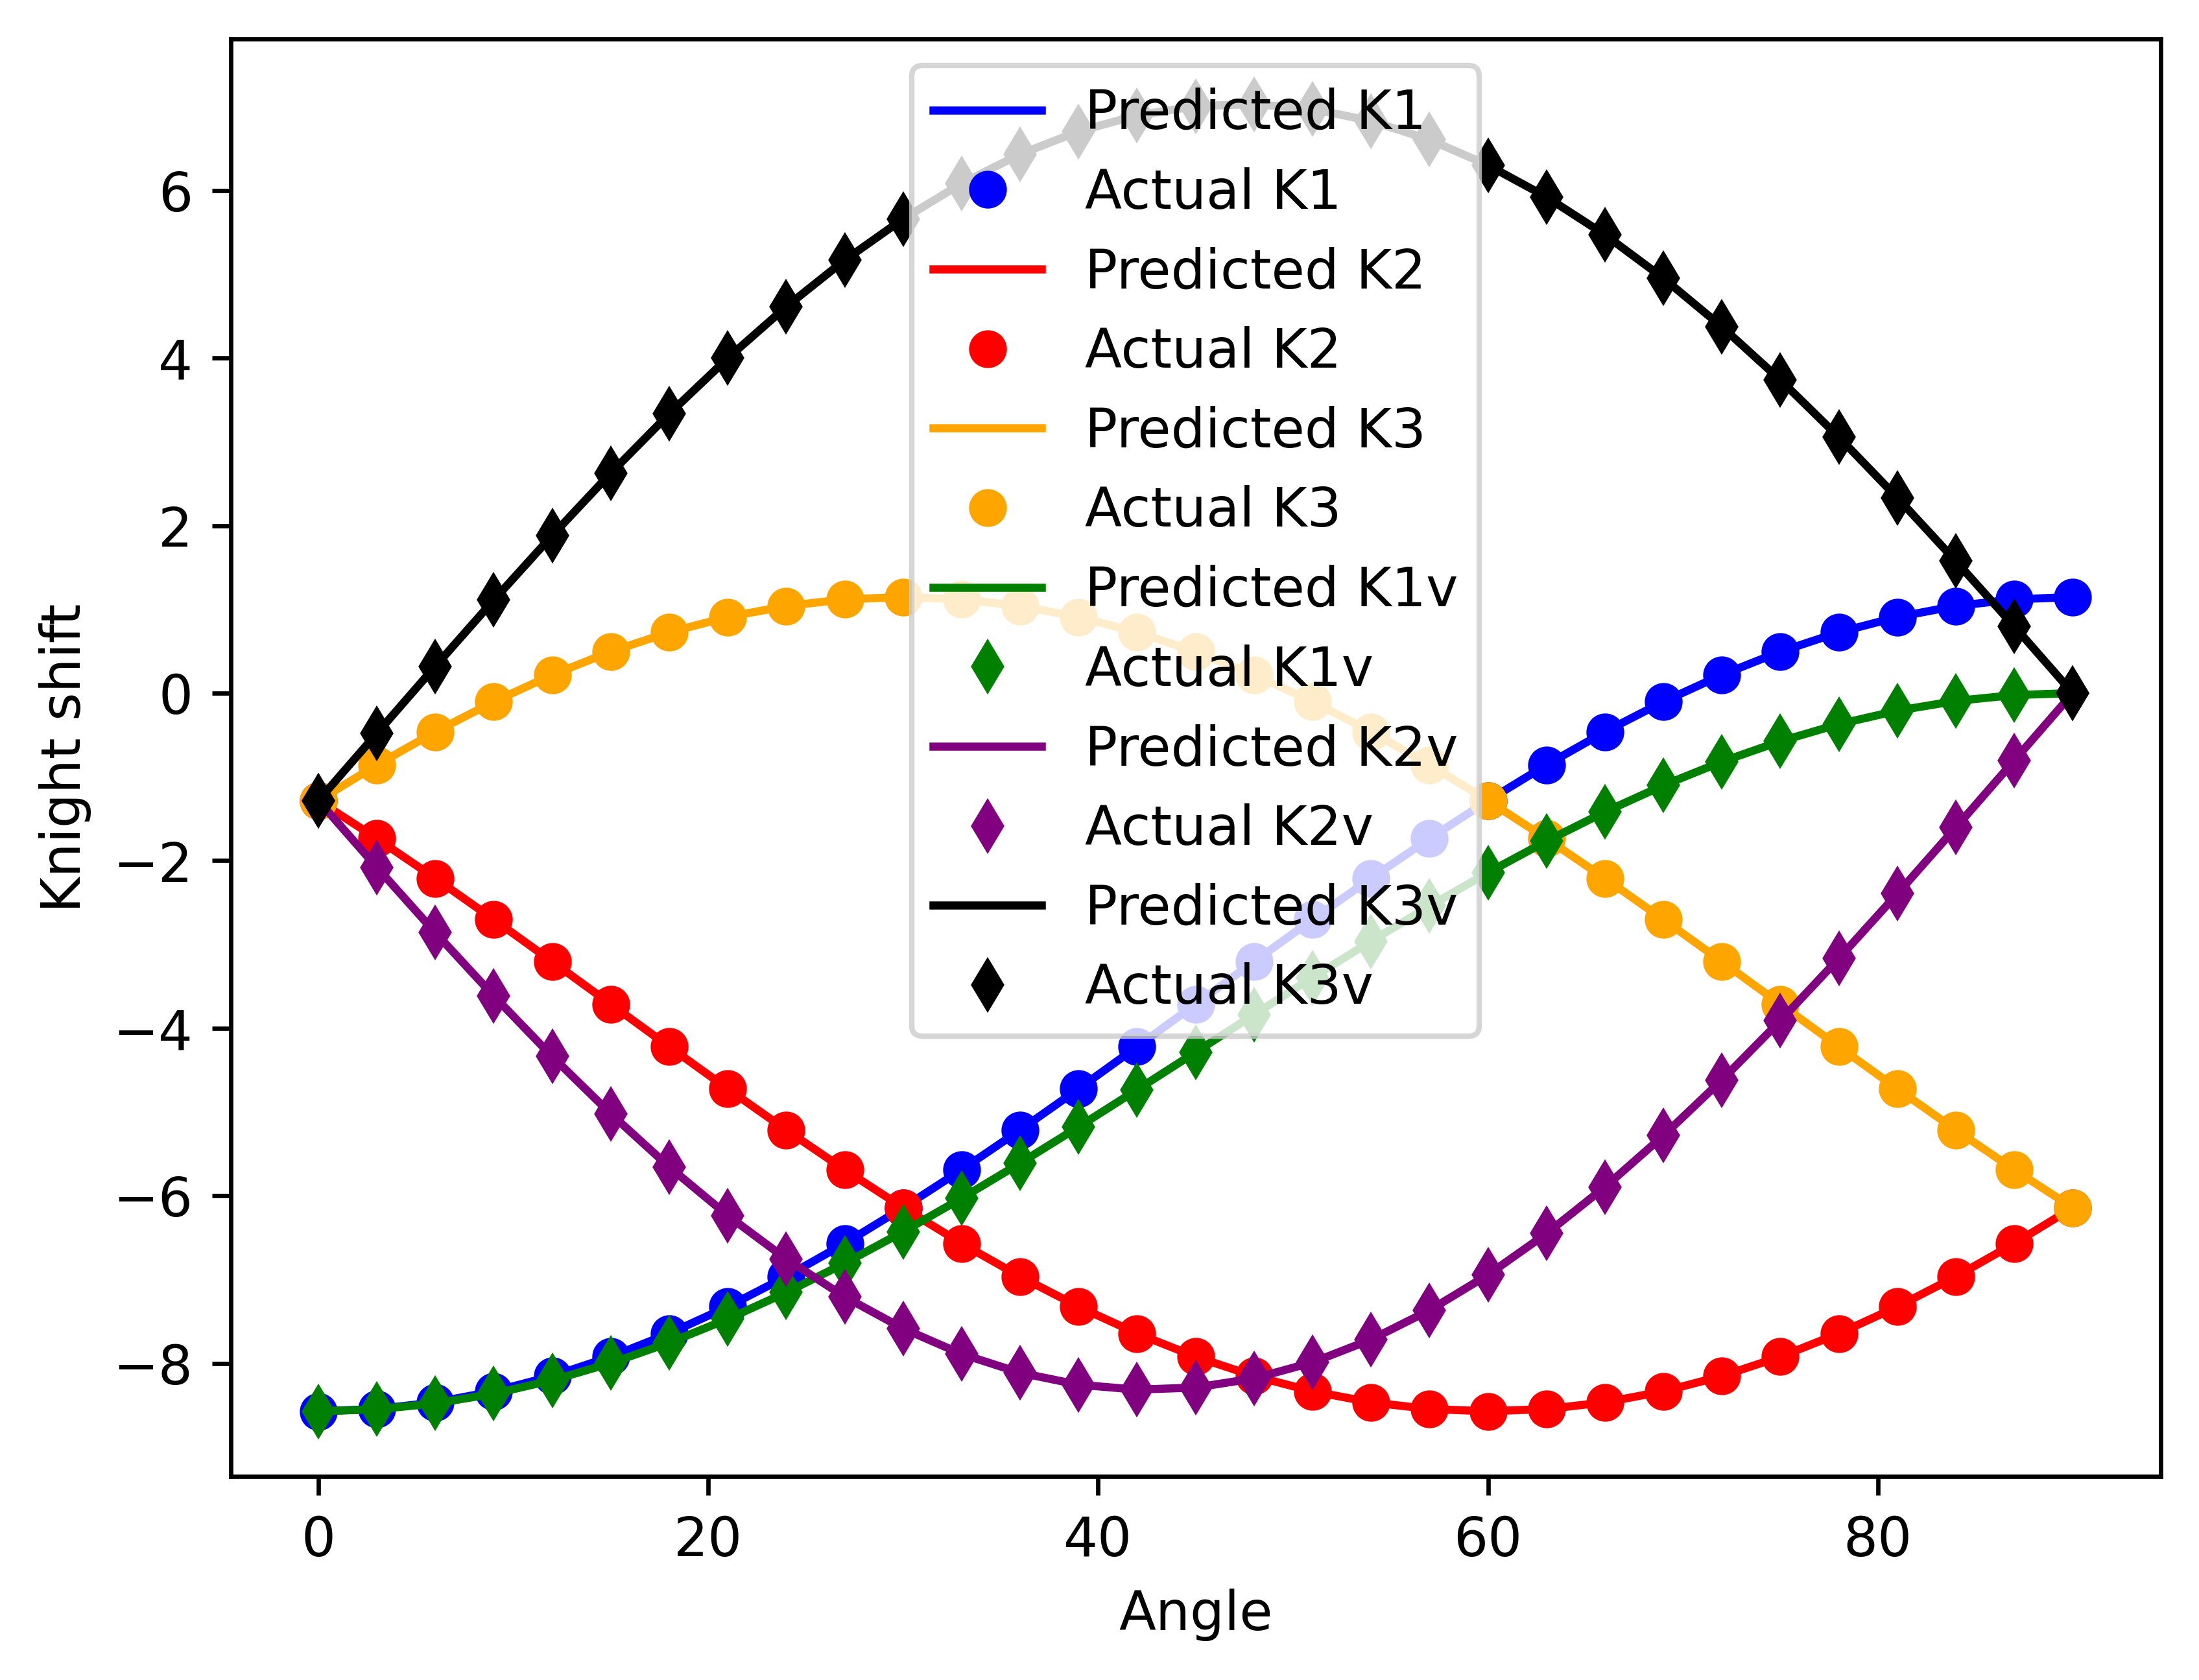

[tensor(-6.5358), tensor(-0.8902), tensor(-3.0635e-07), tensor(7.8506), tensor(-4.0419), tensor(-3.9549), tensor(4.9475e-05), tensor(53.6374), tensor(90.), tensor(27.2415)]


In [18]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'd', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'd', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'd', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(params)